In [1]:
import pandas as pd
import numpy as np
import re
import gensim
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
import spacy
from spacy.lang.en import English
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [2]:
#Load the dataset
df = pd.read_csv("data/modern_slavery_dataset.csv")

In [3]:
#Load the 50d Glove embeddings - need to unzip the zip file in this directory before running this command
embeddings_dict = {}
with open("glove.6B.50d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

# Data Exploration #
First, I'm going to start by doing some data exploration on the UK dataset. The UK Modern Slavery Act has some guidelines for the statements companies release (as detailed here: https://www.lw.com/thoughtLeadership/lw-uk-modern-slavery-act). As a result, I'm going to split the text by each component of the slavery statement guideline, which should enable some more analysis.

In [4]:
#Filter for the UK
uk = df[df["UK Modern Slavery Act"] == True]
#Remove the entries with no text
uk = uk[~uk["Text"].isna()]

In [5]:
nlp = spacy.load('en_vectors_web_lg')

I0103 01:22:25.493542 140116206262080 file_utils.py:41] PyTorch version 1.7.0 available.


I want to extract each major section (policies, supply chain, training, and due diligence) covered under the UK Modern Slavery Act. The ideal way to do this is probably to use a sentence extraction model (like the one provided here: https://github.com/brmson/Sentence-selection) to select the sentences most likely to answer questions like "Is due diligence performed?" However, for now, I'll use regex to identify headers within the slavery statements and determine which of the 4 sections that header is most similar to. 

In [8]:
#These are the sections that seem to appear the most commonly in these documents
section_vectors = {"policies": nlp("policies slavery"), "supply chain": nlp("supply chain structure"), "training": nlp("training"), "due diligence": nlp("due diligence effectiveness")}

def split_into_sections(text):
    #Remove stopwords so that every word in a header hopefully starts with a capital letter
    text = " ".join([word for word in text.split(" ") if word.lower() not in nlp.Defaults.stop_words]) #Remove stopwords
    #Regex to split the text by header
    sections = re.split(r"(?:\n|\x0c)((?:[\d]+[\.]? +){0,1}(?:(?:[A-Z]['\w]+)(?: [\w&,]+){0,6})|[A-Z]{2,}(?: [A-Z]+){0,6})\n", text)
    index = 0
    #A dictionary that contains the text for each section from the statement
    labeled_sections = dict((section, "") for section in section_vectors) 
    while index < len(sections) - 1:
        #I assume that headers are generally shorter than 7 words - if it's longer than this, it's mistakenly identified as a header
        if sections[index] != "" and len(sections[index].split()) < 7:
            max_sim = 0
            section_sim = ""
            #For each header, looks at the section that the header is closest to
            for vec in section_vectors:
                sim = section_vectors[vec].similarity(nlp(sections[index]))
                if sim > max_sim:
                    max_sim = sim
                    section_sim = vec
            #Uses threshold for similarity that I found generally works well in practice
            #The second clause in the if statmenet ensures that the header is followed by a block of text and not another header (like in a table of contents)
            if max_sim > .5 and len(sections[index+1]) > 50:
                labeled_sections[section_sim] = labeled_sections[section_sim] + sections[index+1]
                index += 1
        index += 1
    return np.array([labeled_sections['due diligence'], labeled_sections['policies'], labeled_sections['supply chain'], labeled_sections['training']])


In [9]:
uk["Due Diligence"], uk["Policies"], uk["Supply Chain"], uk["Training"] = np.split(np.array(uk["Text"].apply(split_into_sections).tolist()), 4, axis=1)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.


As I thought, there is a sizable difference in the length of the text for the statements whose policies were able to be identified through Regex and statements whose policies weren't able to be.

In [10]:
uk[uk["Policies"] != ""]["Text"].apply(len).median(), uk[uk["Policies"] == ""]["Text"].apply(len).median()

(6002.0, 3681.0)

# Preprocessing 
Preprocessing was not done earlier because capitalization and newlines were essential to helping to split the document up by headers, but I'll preprocess here by removing numbers, newlines, and punctuation, and then lemmatizing after.

In [11]:
def preprocessing(string):
    if not string:
        return string
    string = re.sub(r"\n", " ", string) #Remove newlines
    string = re.sub("[0-9]", "", string) #Remove numbers
    spacy_str = nlp(string)
    tokens = [token.lemma_.lower() for token in spacy_str if not token.is_punct and not token.like_num]
    return tokens

# Clustering Policies
First, I want to see if there are any clusters that we can identify using T-SNE when visualizing the vectors of the policy section of the statements. Because T-SNE uses dimensionality reduction, to make the process quicker, I decided to use 50-dimensional Glove word embeddings instead of 100 or 300 dimension embeddings. 

In [12]:
uk["Policies Preprocessed"] = uk["Policies"].apply(preprocessing)

Because I assume some words and phrases, like "human trafficking" and "slavery", will occur often across and within documents, I don't want them to have an outsize impact on the vector generated for the final paragraph. As a result, to generate the final vector for each policy section, I'll take the sum of each word vector multiplied by its TF-IDF score.

In [13]:
#calculate tfidf scores for the policies
policies = uk[uk["Policies Preprocessed"] != ""]["Policies Preprocessed"].values
policies = [" ".join(policy) for policy in policies]
tfidf = TfidfVectorizer(min_df=5)
tfidf.fit_transform(policies)

<11223x6802 sparse matrix of type '<class 'numpy.float64'>'
	with 1170597 stored elements in Compressed Sparse Row format>

In [14]:
def get_tfidf_vector(token):
    #If the token is both in the tfidf vocab and has an embedding, multiply the embedding by the tfidf score
    if token in tfidf.vocabulary_ and token in embeddings_dict:
        return embeddings_dict[token]*tfidf.idf_[tfidf.vocabulary_[token]]
    return np.zeros(50)
    

def get_final_vector(tokens):
    vectors = np.array(list(map(get_tfidf_vector, tokens)))
    #Adds up all the vectors in the text
    return list(np.sum(vectors, axis=0))

In [15]:
policy_vectors = uk[uk["Policies Preprocessed"] != ""]["Policies Preprocessed"].apply(get_final_vector)

In [16]:
labels = uk[uk["Policies Preprocessed"] != ""]["Company ID"].values #Get company ID values
policy_vectors = np.array(list(policy_vectors.values)) #Just helps to make 1d array into 2d array

In [17]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23) 
new_values = tsne_model.fit_transform(policy_vectors) #Generates TSNE values

In [18]:
x = []
y = []

#Samples 5000 indices because plotting all the points is too much
indices = np.random.choice(len(labels), 5000, replace=False) 
sampled_values = new_values[indices]
sampled_labels = labels[indices]

for value in sampled_values:
    x.append(value[0])
    y.append(value[1])

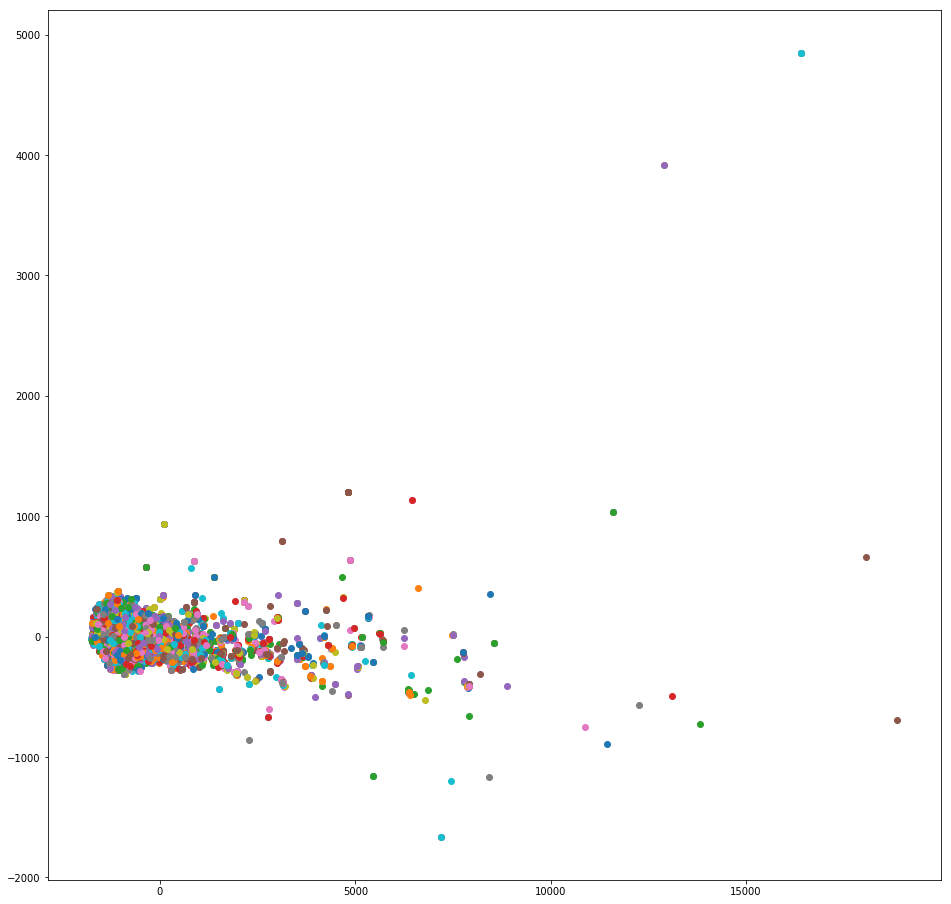

In [19]:
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    #The line below annotates every point but this makes the plot far less legible
    #plt.annotate(sampled_labels[i], xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()

Most of the points seem to be clustered near each other, which makes sense. Analyzing the outliers, however, does reveal some insights. I've identified some of the company ID's of the outliers. These outliers seem to either, talk about policies not directly relevant to human trafficking and slavery, possibly revealing documents included in the corpus that shouldn't be, or policies that go into far more detail than the average document does. For the latter option, analyzing these documents closely might reveal more effective ways to combat slavery than the average company's anti-slavery policy.

In [20]:
#For example, the policies of this company seem to talk extensively about managing its environmental impacts, but
#very little, if at all, about slavery and human trafficking. This would seem to indicate that this document is included
#probably by mistake.
uk[uk["Company ID"] == 25410]["Policies"].values[0]

'As global aluminium company mining interests, ensuring responsible conduct relation society large important Hydro\'s activities. consider impact society, spanning construction divestment closure activity, exposure corruption human rights violations, operations, communities of, supply chain.\nOur compliance shall ensure persons acting behalf Hydro comply applicable laws regulations requirements adopted Hydro. measures pursue ensure integrity responsible behavior include:\n• Zero tolerance corruption private public sector\n• Ongoing human rights diligence, including audits joint ventures suppliers\n• Continuous stakeholder engagement linked existing operations new projects\nHydro’s board-sanctioned Code Conduct creates foundation supports efforts right things act integrity global organization operate conduct business behalf Hydro. requires adherence laws regulations internal constituting documents global directives systematically implemented followed compliance system.\nOur compliance b

In [21]:
#Patagonia's statement talks about policies that the company adopts throughout the supply chain, and is very specific
#about the different initiatives Patagonia has taken to combat human trafficking, including its multi-pronged approach
#to combatting child labor. This level of detail is not generally found in other companies policies, which might explain
#why it's an outlier.
uk[uk["Company ID"] == 9606]["Policies"].values[0]

'Patagonia prohibits forced labor human trafficking forms supply chain. evaluate potential new factory partners, place purchase orders forced labor. forced labor existing partners’ factories, factory subject escalation policy, including remediation plan demonstrate commitment eradicating practice issue. cases, factory Patagonia’s supply chain, incidences conditions contributing slavery human trafficking grounds end business relations eliminated.\nWe fully support efforts growing number anti-slavery activist groups, nongovernmental organizations (NGO’s), state federal government shed light human trafficking, slavery, child labor supply chain. hopeful\n3|Page\n\n\x0cthat human rights concerns continue receive attention analysis public private spheres.\nWe welcome feedback disclosure statement. email social_responsibility@patagonia.com.\nB. DISCLOSURE PATAGONIA PURSUANT CALIFORNIA TRANSPARENCY SUPPLY CHAINS ACT UK MODERN SLAVERY ACT\nFocusing topic areas covered California Transparency Ac

In [22]:
#This is only a snippet of this company's policies, but the full document is very detailed about the company's policies
#regarding breaches, communication, and company responsibiity. Again, it is this specificity that might explain why this
#document is an outlier.
uk[uk["Company ID"] == 32846]["Policies"].values[0][:2000]

"1.1 Modern slavery crime violation fundamental human rights. takes forms, slavery, servitude, forced compulsory labour human trafficking, common deprivation person's liberty order exploit personal commercial gain. includes forced labour human trafficking labour exploitation; payment work-finding services work-related exploitation forced use accommodation. understood hidden perpetrators victims, perceive such, reluctant come forward.\n1.2 zero-tolerance approach modern slavery committed acting ethically integrity business dealings relationships implementing enforcing effective systems controls ensure modern slavery taking place business supply chains.\n1.3 committed ensuring transparency business approach tackling modern slavery supply chains, consistent disclosure obligations Modern Slavery Act 2015. expect high standards contractors, suppliers business partners, contracting processes, include specific prohibitions use forced, compulsory trafficked labour, held slavery servitude, adul

# Comparing Due Diligence and Supply Chain

Two sections of the report that should relate to each other closely are the due diligence and supply chain sections. This is because the supply chain sections should enumerate the risks present at every stage of the supply chain, while the due diligence section should discuss the steps taken to manage those risks. Companies that produce good statements are thus likely to use similar terminology in both the due diligence and the supply chain sections, meaning taking the cosine similarity between the two vectors should hopefully reveal which companies are doing better jobs than others at mitigating the risks they've identified in their supply chain.

In [23]:
uk_supply_diligence = uk.loc[:, ["Company ID", "Company", "Supply Chain", "Due Diligence"]] #Create new DF
uk_supply_diligence["Supply Preprocessed"] = uk_supply_diligence["Supply Chain"].apply(preprocessing)
uk_supply_diligence["Diligence Preprocessed"] = uk_supply_diligence["Due Diligence"].apply(preprocessing)

In [26]:
#Only selects the rows of the dataframe that have non-empty due diligence and supply chain values
uk_supply_diligence = uk_supply_diligence[(uk_supply_diligence["Supply Preprocessed"] != "") & (uk_supply_diligence["Diligence Preprocessed"] != "")]
supply_chain = uk_supply_diligence["Supply Preprocessed"].values
diligence = uk_supply_diligence["Diligence Preprocessed"].values
supply_chain = [" ".join(chain) for chain in supply_chain]
diligence = [" ".join(text) for text in diligence]
#Generates tfidf values for the supply chain and due diligence texts - in this case, it's better to process them together
tfidf.fit_transform(supply_chain + diligence)

<15240x9796 sparse matrix of type '<class 'numpy.float64'>'
	with 1635175 stored elements in Compressed Sparse Row format>

In [27]:
def get_cos_similarity(row):
    supply = row["Supply Preprocessed"]
    diligence = row["Diligence Preprocessed"]
    supply_vector = [get_final_vector(supply)] #Needs to be a 2d array for the cosine_similarity function
    diligence_vector = [get_final_vector(diligence)]
    return cosine_similarity(supply_vector, diligence_vector)[0][0] #Retrieve the cosine_similarity value

In [28]:
#Calculates cosine similarity values for every row
uk_supply_diligence["Cosine Similarity"] = uk_supply_diligence.apply(get_cos_similarity, axis=1)
#Sort dataframe by descending cosine similarity 
uk_supply_diligence = uk_supply_diligence.sort_values(by="Cosine Similarity", ascending=False)

In [29]:
#Looking at the top results in this dataframe also reveals that their due diligence and supply chain sections are 
#often incredibly detailed, which could be viewed as a proxy metric for a better slavery statement.
uk_supply_diligence.head()

,Company ID,Company,Supply Chain,Due Diligence,Supply Preprocessed,Diligence Preprocessed,Cosine Similarity
5629,9037,Capgemini UK plc,We global network Capgemini entities Capgemini...,This Transparency Statement pursuant Section 5...,"[we, global, network, capgemini, entity, capge...","[this, transparency, statement, pursuant, sect...",0.995376
21969,36745,Severn Trent Green Power Ltd,"We spend £1.25bn year supply chain, rely 1,700...","\nWe’re proud purposeful company, committed pr...","[we, spend, £, .bn, year, supply, chain, rely,...","[ , -pron-, be, proud, purposeful, company, co...",0.994335
21968,36746,Hafren Dyfrdwy Cyfyngedig,"We spend £1.25bn year supply chain, rely 1,700...","\nWe’re proud purposeful company, committed pr...","[we, spend, £, .bn, year, supply, chain, rely,...","[ , -pron-, be, proud, purposeful, company, co...",0.994335
21972,31115,Severn Trent Water Limited,"We spend £1.25bn year supply chain, rely 1,700...","\nWe’re proud purposeful company, committed pr...","[we, spend, £, .bn, year, supply, chain, rely,...","[ , -pron-, be, proud, purposeful, company, co...",0.994335
21971,31118,Severn Trent Services Operations UK Limited,"We spend £1.25bn year supply chain, rely 1,700...","\nWe’re proud purposeful company, committed pr...","[we, spend, £, .bn, year, supply, chain, rely,...","[ , -pron-, be, proud, purposeful, company, co...",0.994335


# Conclusions and Future Directions
The biggest improvement to my analysis would be to use a pretrained model to extract sentences most likely to pertain to each section that slavery statements should include. This would ensure that extracted sentences are more relevant and do not contain extraneous information. Additionally, my analysis in this notebook was limited to statements covered under the UK statement, but a promising direction for future analysis would be to analyze differences between statements covered by different policies to find any significant differences in the phrasing of the slavery statements. 